<a href="https://colab.research.google.com/github/Jung1016/python/blob/main/GAN_NonSmile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
pwd

'/content/drive/MyDrive/archive'

In [ ]:
cd /content/drive/MyDrive/archive/non_smile

/content/drive/MyDrive/archive/non_smile


Text(0.5, 1.0, 'Non_Smile')

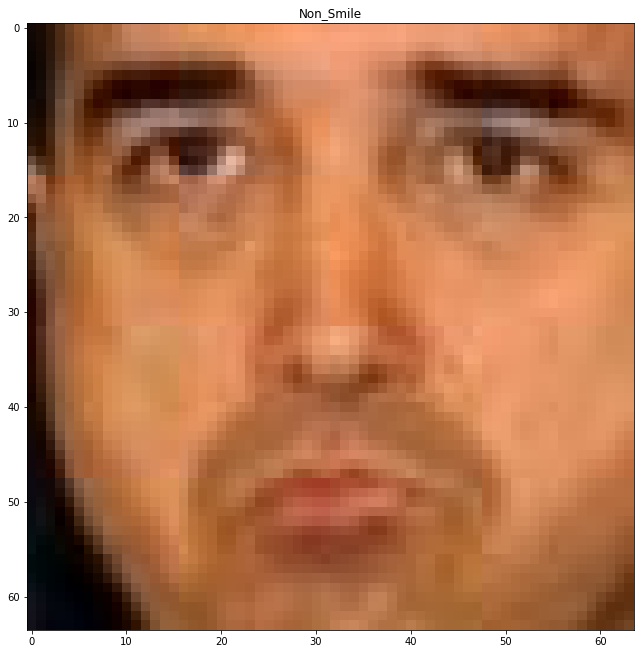

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.color import rgb2lab, rgb2gray, lab2rgb

image_sample = imread('Arnaud_Lagardere_0001.jpg')
fig, ax = plt.subplots(figsize = (9, 16))
imshow(image_sample, ax = ax)
ax.set_title('Non_Smile')

In [ ]:
cd ..

/content/drive/MyDrive/archive


In [ ]:
ls

non_smile/  smile/


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from keras import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Reshape, LeakyReLU
from keras.models import Sequential

train_gen = ImageDataGenerator(
    rescale = 1./255,
)

train = train_gen.flow_from_directory(directory = '.', classes = ['non_smile'],
                                      target_size = (64, 64), 
                                      color_mode = 'rgb',
                                      batch_size = 1)

len(train[0][0])

Found 603 images belonging to 1 classes.


1

In [ ]:
x_train = np.array(train[0][0])

for i in range(1, 603):
  x_train = np.append(x_train, train[i][0], axis = 0)

x_train.shape

(603, 64, 64, 3)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
4/4 [==============================] - 0s 8ms/step
6000 [D loss: 0.561894, acc, : 73.83%] [G loss: 1.444767]
4/4 [==============================] - 0s 8ms/step
7000 [D loss: 0.804261, acc, : 43.36%] [G loss: 0.926619]
4/4 [==============================] - 0s 8ms/step
8000 [D loss: 0.820552, acc, : 39.84%] [G loss: 1.182366]
4/4 [==============================] - 0s 7ms/step
9000 [D loss: 0.411686, acc, : 91.41%] [G loss: 1.512674]
4/4 [==============================] - 0s 7ms/step
10000 [D loss: 0.431606, acc, : 80.47%] [G loss: 1.625553]
1/1 [==============================] - 0s 18ms/step


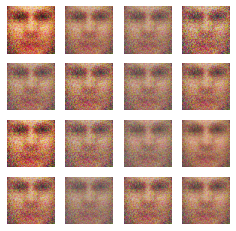

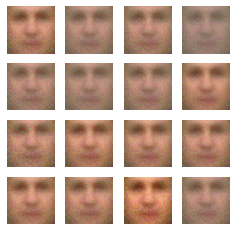

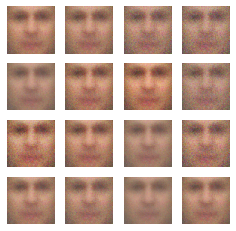

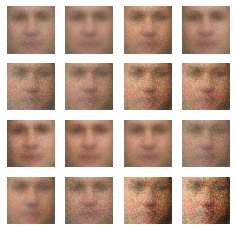

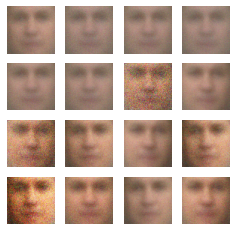

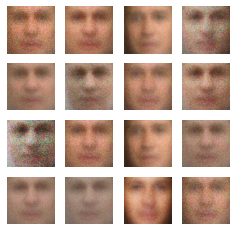

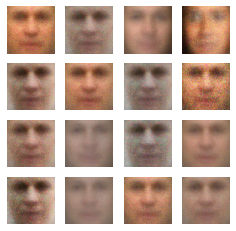

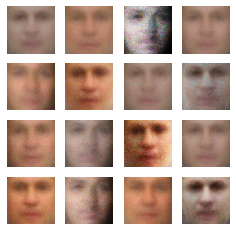

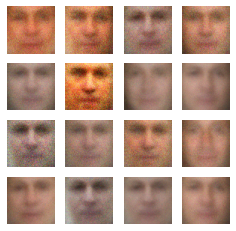

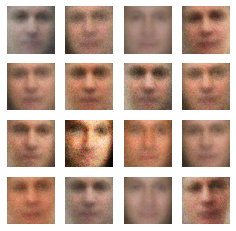

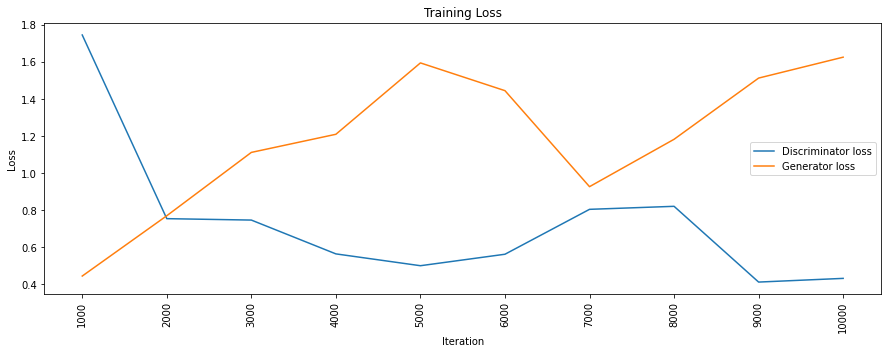

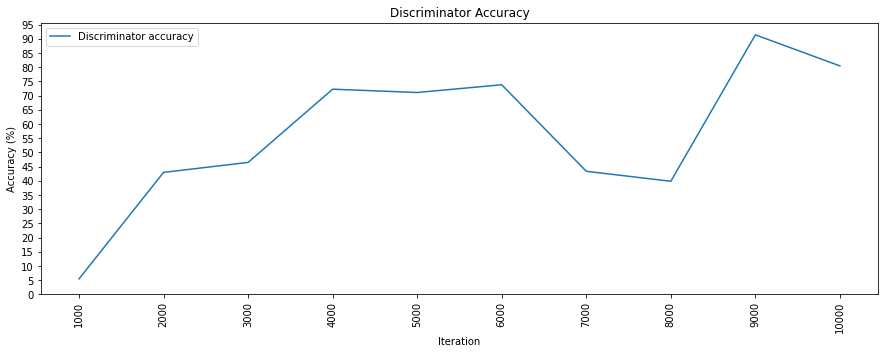

In [ ]:
img_rows = 64
img_cols = 64
channels = 3
img_shape = (img_rows, img_cols, channels)
z_dim = 100

def build_generator(img_shape, z_dim):
  model = Sequential()
  model.add(Dense(80, input_dim = z_dim))
  model.add(LeakyReLU(alpha = 0.02))
  model.add(Dense(64 * 64 * 3, activation = 'sigmoid'))
  model.add(Reshape(img_shape))
  return model

def build_discriminator(img_shape):
  model = Sequential()
  model.add(Flatten(input_shape = img_shape))
  model.add(Dense(200))
  model.add(LeakyReLU(alpha = 0.02))
  model.add(Dense(1, activation = 'sigmoid'))
  return model

def build_gan(generator, discriminator):
  model = Sequential()
  model.add(generator)
  discriminator.trainable = False
  model.add(discriminator)
  return model

discriminator = build_discriminator(img_shape)
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

generator = build_generator(img_shape, z_dim)

gan = build_gan(generator, discriminator)
gan.compile(loss = 'binary_crossentropy', optimizer = 'adam')

losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval, x_trains):

  x_train = x_trains

  real = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for iteration in range(iterations):
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    imgs = x_train[idx]

    z = np.random.normal(0,1, (batch_size, 100))
    gen_imgs = generator.predict(z)
    
    discriminator.trainable = True

    d_loss_real = discriminator.train_on_batch(imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

    discriminator.trainable = False

    z = np.random.normal(0, 1, (batch_size, 100))
    g_loss = gan.train_on_batch(z, real)

    if(iteration + 1) % sample_interval == 0:
      losses.append((d_loss, g_loss))
      accuracies.append(100.0 * accuracy)
      iteration_checkpoints.append(iteration + 1)

      print("%d [D loss: %f, acc, : %.2f%%] [G loss: %f]" %
            (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
      
      sample_images(generator)

def sample_images(generator, image_grid_rows = 4, image_grid_columns = 4):
  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

  gen_imgs = generator.predict(z)

  fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize = (4, 4), sharey = True, sharex = True)

  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      axs[i, j].imshow(gen_imgs[cnt, :, :, :]) #cmap 없으면 컬러, cmap = 'gray'면 흑백
      axs[i, j].axis('off')
      cnt += 1

iterations = 10000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval, x_train)

losses = np.array(losses)

plt.figure(figsize = (15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label = "Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label = "Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

accuracies = np.array(accuracies)

plt.figure(figsize = (15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation = 90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()